# Step 1: Experiment with PyTorch Autoencoder for Anomaly Detection
<div class="alert alert-warning"> This notebook demonstrates anomaly detection using PyTorch autoencoders on banking customer data - optimized for SageMaker</div>

In this customized version, we use the same banking dataset but transform the problem into **anomaly detection** using a **PyTorch autoencoder neural network**.

**Problem Statement**: Detect anomalous customer behavior patterns that might indicate:
- Fraudulent activities
- Data quality issues
- Unusual customer segments

**Key improvements over TensorFlow version:**
- ✅ Better SageMaker GPU compatibility
- ✅ No libdevice.10.bc errors
- ✅ Robust CPU/GPU fallback strategy
- ✅ Optimized for banking anomaly detection

**From idea to production in five steps:**
||||
|---|---|---|
|1. |Experiment with autoencoder in a notebook |**<<<< YOU ARE HERE**|
|2. |Scale with SageMaker AI processing jobs and SageMaker SDK ||
|3. |Operationalize with ML pipeline, model registry ||
|4. |Add a model deployment pipeline ||
|5. |Add streaming inference with SQS ||


In [1]:
# SageMaker-optimized PyTorch setup
import os
import subprocess
import sys
import warnings
warnings.filterwarnings('ignore')

print("🔧 Configuring SageMaker for PyTorch usage...")

# Check if we're running on SageMaker
def is_sagemaker_environment():
    return os.path.exists('/opt/ml') or 'SM_' in os.environ

# Check GPU availability
def check_gpu_setup():
    try:
        result = subprocess.run(['nvidia-smi'], capture_output=True, text=True)
        if result.returncode == 0:
            print("✅ NVIDIA GPU detected:")
            lines = result.stdout.split('\n')
            for line in lines:
                if 'Tesla' in line or 'V100' in line or 'A100' in line or 'T4' in line:
                    print(f"   📊 {line.strip()}")
            return True
        else:
            print("ℹ️  No GPU detected - using CPU instance")
            return False
    except FileNotFoundError:
        print("ℹ️  nvidia-smi not found - likely CPU instance")
        return False

gpu_available = check_gpu_setup()

if is_sagemaker_environment():
    print("🚀 Running on SageMaker - optimizing for production environment")
    # Check instance type
    try:
        with open('/opt/ml/input/config/resourceconfig.json', 'r') as f:
            import json
            config = json.load(f)
            instance_type = config.get('current_host', 'unknown')
            print(f"📋 SageMaker instance type: {instance_type}")
    except:
        print("📋 Instance type: Unknown (likely notebook instance)")
else:
    print("ℹ️  Not running on SageMaker - using local configuration")

print("🔧 SageMaker PyTorch configuration complete")

🔧 Configuring SageMaker for PyTorch usage...
✅ NVIDIA GPU detected:
   📊 |   0  Tesla T4                       On  |   00000000:00:1E.0 Off |                    0 |
🚀 Running on SageMaker - optimizing for production environment
📋 Instance type: Unknown (likely notebook instance)
🔧 SageMaker PyTorch configuration complete


In [2]:
%store -r 

%store

try:
    initialized
except NameError:
    print("+++++++++++++++++++++++++++++++++++++++++++++++++")
    print("[ERROR] YOU HAVE TO RUN 00-start-here notebook   ")
    print("+++++++++++++++++++++++++++++++++++++++++++++++++")

Unable to restore variable 'pytorch_estimator', ignoring (use %store -d to forget!)
The error was: <class 'KeyError'>
Stored variables and their in-db values:
baseline_s3_url                        -> 's3://sagemaker-us-west-2-224425919845/from-idea-t
bucket_name                            -> 'sagemaker-us-west-2-224425919845'
bucket_prefix                          -> 'from-idea-to-prod/autoencoder'
dataset_file_local_path                -> 'data/bank-additional/bank-additional-full.csv'
domain_id                              -> 'd-rtctvdud9qsp'
endpoint_name                          -> 'from-idea-to-prod-autoencoder-endpoint-06-04-51-2
evaluation_s3_url                      -> 's3://sagemaker-us-west-2-224425919845/from-idea-t
initialized                            -> True
input_s3_url                           -> 's3://sagemaker-us-west-2-224425919845/from-idea-t
mlflow_arn                             -> 'arn:aws:sagemaker:us-west-2:224425919845:mlflow-t
mlflow_name                  

In [3]:
# PyTorch imports and configuration
import pandas as pd
import numpy as np 
import json
import joblib
import os
import warnings
warnings.filterwarnings('ignore')

# PyTorch imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F

# Other ML libraries
import sagemaker
import boto3
import matplotlib.pyplot as plt
import seaborn as sns
import mlflow
import mlflow.pytorch
from mlflow.models import infer_signature
from time import gmtime, strftime, sleep
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Configure PyTorch device with robust GPU/CPU handling
print("🔧 Configuring PyTorch device strategy...")

def get_device():
    """Get the best available device for PyTorch"""
    if torch.cuda.is_available():
        device = torch.device('cuda')
        print(f"✅ CUDA available: {torch.cuda.get_device_name(0)}")
        print(f"📊 CUDA version: {torch.version.cuda}")
        print(f"🔥 PyTorch version: {torch.__version__}")
        return device
    else:
        device = torch.device('cpu')
        print("🖥️  Using CPU device")
        print(f"🔥 PyTorch version: {torch.__version__}")
        return device

device = get_device()
print(f"🎯 Selected device: {device}")

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

print(f"SageMaker version: {sagemaker.__version__}")
print(f"MLflow version: {mlflow.__version__}")
print("🚀 PyTorch setup complete!")

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Fetched defaults config from location: /home/sagemaker-user/.config/sagemaker/config.yaml
🔧 Configuring PyTorch device strategy...
✅ CUDA available: Tesla T4
📊 CUDA version: 12.6
🔥 PyTorch version: 2.6.0
🎯 Selected device: cuda
SageMaker version: 2.249.0
MLflow version: 2.22.1
🚀 PyTorch setup complete!


In [4]:
# Load stored variables from setup notebook
%store -r 
%store

try:
    initialized
except NameError:
    print("+++++++++++++++++++++++++++++++++++++++++++++++++")
    print("[ERROR] YOU HAVE TO RUN 00-start-here notebook   ")
    print("+++++++++++++++++++++++++++++++++++++++++++++++++")

Unable to restore variable 'pytorch_estimator', ignoring (use %store -d to forget!)
The error was: <class 'KeyError'>
Stored variables and their in-db values:
baseline_s3_url                        -> 's3://sagemaker-us-west-2-224425919845/from-idea-t
bucket_name                            -> 'sagemaker-us-west-2-224425919845'
bucket_prefix                          -> 'from-idea-to-prod/autoencoder'
dataset_file_local_path                -> 'data/bank-additional/bank-additional-full.csv'
domain_id                              -> 'd-rtctvdud9qsp'
endpoint_name                          -> 'from-idea-to-prod-autoencoder-endpoint-06-04-51-2
evaluation_s3_url                      -> 's3://sagemaker-us-west-2-224425919845/from-idea-t
initialized                            -> True
input_s3_url                           -> 's3://sagemaker-us-west-2-224425919845/from-idea-t
mlflow_arn                             -> 'arn:aws:sagemaker:us-west-2:224425919845:mlflow-t
mlflow_name                  

In [5]:
session = sagemaker.Session()
sm = session.sagemaker_client

## Load and Prepare Data for Anomaly Detection
We'll use the same banking dataset but approach it as an unsupervised learning problem for anomaly detection.

In [6]:
# Load the banking dataset
file_source = "local"
file_name = "bank-additional-full.csv"
input_path = "./data/bank-additional" 
output_path = "./data"

# Load data
df = pd.read_csv(os.path.join(input_path, file_name), sep=';')
print(f"Dataset shape: {df.shape}")
print(f"Columns: {list(df.columns)}")
df.head()

Dataset shape: (41188, 21)
Columns: ['age', 'job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed', 'y']


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


## Exploratory Data Analysis for Anomaly Detection
Let's analyze the data to understand normal patterns before building our autoencoder.

In [7]:
# Basic statistics
print("Dataset Info:")
print(f"Shape: {df.shape}")
print(f"Missing values: {df.isnull().sum().sum()}")
print(f"Duplicate rows: {df.duplicated().sum()}")

# Display data types
print("\nData Types:")
print(df.dtypes)

# Show target distribution (we'll use this to create synthetic anomalies for validation)
print("\nTarget Distribution (for reference):")
print(df['y'].value_counts())

Dataset Info:
Shape: (41188, 21)
Missing values: 0
Duplicate rows: 12

Data Types:
age                 int64
job                object
marital            object
education          object
default            object
housing            object
loan               object
contact            object
month              object
day_of_week        object
duration            int64
campaign            int64
pdays               int64
previous            int64
poutcome           object
emp.var.rate      float64
cons.price.idx    float64
cons.conf.idx     float64
euribor3m         float64
nr.employed       float64
y                  object
dtype: object

Target Distribution (for reference):
y
no     36548
yes     4640
Name: count, dtype: int64


In [8]:
# Data preprocessing for autoencoder
def preprocess_data_for_autoencoder(df):
    """
    Preprocess banking data for autoencoder anomaly detection
    """
    # Make a copy
    data = df.copy()
    
    # Remove target column for unsupervised learning
    if 'y' in data.columns:
        target = data['y']
        data = data.drop('y', axis=1)
    
    # Identify categorical and numerical columns
    categorical_cols = data.select_dtypes(include=['object']).columns.tolist()
    numerical_cols = data.select_dtypes(include=['int64', 'float64']).columns.tolist()
    
    print(f"Categorical columns: {categorical_cols}")
    print(f"Numerical columns: {numerical_cols}")
    
    # Handle categorical variables with label encoding
    label_encoders = {}
    for col in categorical_cols:
        le = LabelEncoder()
        data[col] = le.fit_transform(data[col].astype(str))
        label_encoders[col] = le
    
    # Scale all features
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data)
    
    return scaled_data, scaler, label_encoders, data.columns.tolist(), target if 'y' in df.columns else None

# Preprocess the data
X_scaled, scaler, label_encoders, feature_names, y_original = preprocess_data_for_autoencoder(df)
print(f"Preprocessed data shape: {X_scaled.shape}")
print(f"Feature names: {feature_names}")

Categorical columns: ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']
Numerical columns: ['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']
Preprocessed data shape: (41188, 20)
Feature names: ['age', 'job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']


## PyTorch Autoencoder Architecture
We'll build a deep autoencoder using PyTorch to learn the normal patterns in customer data.

In [9]:
class BankingAutoencoder(nn.Module):
    """
    PyTorch Autoencoder for Banking Customer Anomaly Detection
    Optimized for SageMaker deployment
    """
    def __init__(self, input_dim, encoding_dim=10, dropout_rate=0.1):
        super(BankingAutoencoder, self).__init__()
        
        self.input_dim = input_dim
        self.encoding_dim = encoding_dim
        
        # Encoder layers - progressively reduce dimensions
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(32, encoding_dim),
            nn.ReLU()
        )
        
        # Decoder layers - progressively increase dimensions
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 32),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(64, input_dim)
        )
        
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
    def encode(self, x):
        """Get encoded representation"""
        return self.encoder(x)
    
    def get_reconstruction_error(self, x):
        """Calculate reconstruction error for anomaly detection"""
        with torch.no_grad():
            reconstructed = self.forward(x)
            error = F.mse_loss(reconstructed, x, reduction='none')
            return error.mean(dim=1)  # Mean error per sample

def create_data_loader(X, batch_size=32, shuffle=True):
    """Create PyTorch DataLoader from numpy array"""
    tensor_data = torch.FloatTensor(X)
    dataset = TensorDataset(tensor_data, tensor_data)  # Input = Target for autoencoder
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

# Build the autoencoder
input_dim = X_scaled.shape[1]
encoding_dim = max(5, input_dim // 4)  # Adaptive encoding dimension

print(f"Input dimension: {input_dim}")
print(f"Encoding dimension: {encoding_dim}")
print(f"Compression ratio: {input_dim/encoding_dim:.2f}x")

# Initialize model
autoencoder = BankingAutoencoder(input_dim, encoding_dim).to(device)
print(f"\n🏗️  Model architecture:")
print(autoencoder)
print(f"\n📊 Total parameters: {sum(p.numel() for p in autoencoder.parameters()):,}")

Input dimension: 20
Encoding dimension: 5
Compression ratio: 4.00x

🏗️  Model architecture:
BankingAutoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=64, out_features=32, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.1, inplace=False)
    (6): Linear(in_features=32, out_features=5, bias=True)
    (7): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=5, out_features=32, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=32, out_features=64, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.1, inplace=False)
    (6): Linear(in_features=64, out_features=20, bias=True)
  )
)

📊 Total parameters: 7,193


## Training the PyTorch Autoencoder
We'll train the autoencoder on 'normal' data to learn typical customer patterns.

In [10]:
# For anomaly detection, we typically train on 'normal' data only
# In this case, we'll use customers who didn't subscribe (majority class) as 'normal'
# and those who subscribed as potential 'anomalies' for validation

if y_original is not None:
    # Use 'no' responses as normal data for training
    normal_mask = (y_original == 'no')
    X_normal = X_scaled[normal_mask]
    X_anomaly_validation = X_scaled[~normal_mask]  # For validation
    
    print(f"Normal samples for training: {X_normal.shape[0]}")
    print(f"Anomaly samples for validation: {X_anomaly_validation.shape[0]}")
else:
    # If no target available, use all data
    X_normal = X_scaled
    X_anomaly_validation = None
    print(f"Using all {X_normal.shape[0]} samples for training")

# Split normal data into train/validation
X_train, X_val = train_test_split(X_normal, test_size=0.2, random_state=42)

print(f"Training set shape: {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")

# Create data loaders
train_loader = create_data_loader(X_train, batch_size=32, shuffle=True)
val_loader = create_data_loader(X_val, batch_size=32, shuffle=False)

print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")

Normal samples for training: 36548
Anomaly samples for validation: 4640
Training set shape: (29238, 20)
Validation set shape: (7310, 20)
Training batches: 914
Validation batches: 229


In [11]:
def train_epoch(model, train_loader, optimizer, criterion, device):
    """Train for one epoch"""
    model.train()
    total_loss = 0
    num_batches = 0
    
    for batch_data, _ in train_loader:
        batch_data = batch_data.to(device)
        
        optimizer.zero_grad()
        reconstructed = model(batch_data)
        loss = criterion(reconstructed, batch_data)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        num_batches += 1
    
    return total_loss / num_batches

def validate_epoch(model, val_loader, criterion, device):
    """Validate for one epoch"""
    model.eval()
    total_loss = 0
    num_batches = 0
    
    with torch.no_grad():
        for batch_data, _ in val_loader:
            batch_data = batch_data.to(device)
            reconstructed = model(batch_data)
            loss = criterion(reconstructed, batch_data)
            total_loss += loss.item()
            num_batches += 1
    
    return total_loss / num_batches

def train_autoencoder(model, train_loader, val_loader, device, epochs=100, lr=0.001, patience=10):
    """Train the autoencoder with early stopping"""
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, min_lr=1e-7)
    
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    patience_counter = 0
    best_model_state = None
    
    print(f"🚀 Starting training on {device}...")
    print(f"📊 Training batches: {len(train_loader)}, Validation batches: {len(val_loader)}")
    
    for epoch in range(epochs):
        # Training
        train_loss = train_epoch(model, train_loader, optimizer, criterion, device)
        
        # Validation
        val_loss = validate_epoch(model, val_loader, criterion, device)
        
        # Learning rate scheduling
        scheduler.step(val_loss)
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        
        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            best_model_state = model.state_dict().copy()
        else:
            patience_counter += 1
        
        # Print progress
        if (epoch + 1) % 10 == 0 or epoch == 0:
            current_lr = optimizer.param_groups[0]['lr']
            print(f"Epoch {epoch+1:3d}/{epochs} | Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f} | LR: {current_lr:.2e}")
        
        # Early stopping check
        if patience_counter >= patience:
            print(f"\n⏹️  Early stopping at epoch {epoch+1} (patience={patience})")
            break
    
    # Restore best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        print(f"✅ Restored best model with validation loss: {best_val_loss:.6f}")
    
    return {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'best_val_loss': best_val_loss,
        'epochs_trained': len(train_losses)
    }

In [12]:
print(f'Using MLflow server: {mlflow_arn}')
mlflow.set_tracking_uri(mlflow_arn)
experiment = mlflow.set_experiment(experiment_name="pytorch-autoencoder-anomaly-detection")

Using MLflow server: arn:aws:sagemaker:us-west-2:224425919845:mlflow-tracking-server/mlflow-d-rtctvdud9qsp


🚀 Starting training on cuda...
📊 Training batches: 914, Validation batches: 229
Epoch   1/100 | Train Loss: 0.621823 | Val Loss: 0.478595 | LR: 1.00e-03
Epoch  10/100 | Train Loss: 0.341157 | Val Loss: 0.273545 | LR: 1.00e-03
Epoch  20/100 | Train Loss: 0.305319 | Val Loss: 0.235846 | LR: 1.00e-03
Epoch  30/100 | Train Loss: 0.284477 | Val Loss: 0.212656 | LR: 1.00e-03
Epoch  40/100 | Train Loss: 0.259260 | Val Loss: 0.182118 | LR: 1.00e-03
Epoch  50/100 | Train Loss: 0.244332 | Val Loss: 0.170152 | LR: 1.00e-03
Epoch  60/100 | Train Loss: 0.238799 | Val Loss: 0.166759 | LR: 1.00e-03
Epoch  70/100 | Train Loss: 0.226819 | Val Loss: 0.157628 | LR: 5.00e-04
Epoch  80/100 | Train Loss: 0.221927 | Val Loss: 0.154037 | LR: 5.00e-04
Epoch  90/100 | Train Loss: 0.217019 | Val Loss: 0.150293 | LR: 2.50e-04
Epoch 100/100 | Train Loss: 0.216618 | Val Loss: 0.149046 | LR: 2.50e-04
✅ Restored best model with validation loss: 0.148557


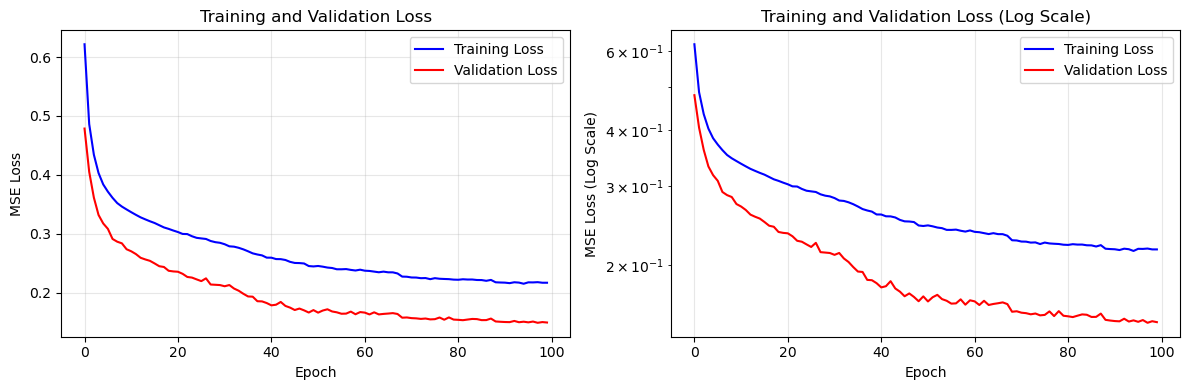


🎉 Training completed successfully!
📊 Final training loss: 0.216618
📊 Best validation loss: 0.148557
🖥️  Device used: cuda
⏱️  Epochs trained: 100
Run Id:71decaee0c4a43b2a78a0d86251a8712
🏃 View run pytorch_autoencoder_banking at: https://us-west-2.experiments.sagemaker.aws/#/experiments/1/runs/71decaee0c4a43b2a78a0d86251a8712
🧪 View experiment at: https://us-west-2.experiments.sagemaker.aws/#/experiments/1


In [13]:
# Start MLflow experiment tracking
mlflow.set_experiment("pytorch-autoencoder-anomaly-detection")

with mlflow.start_run(run_name="pytorch_autoencoder_banking"):
    # Log parameters
    mlflow.log_param("framework", "PyTorch")
    mlflow.log_param("device", str(device))
    mlflow.log_param("input_dim", input_dim)
    mlflow.log_param("encoding_dim", encoding_dim)
    mlflow.log_param("train_samples", X_train.shape[0])
    mlflow.log_param("val_samples", X_val.shape[0])
    mlflow.log_param("model_parameters", sum(p.numel() for p in autoencoder.parameters()))
    
    # Train the model
    training_results = train_autoencoder(
        autoencoder, 
        train_loader, 
        val_loader, 
        device, 
        epochs=100, 
        lr=0.001, 
        patience=15
    )
    
    # Log metrics
    mlflow.log_metric("final_train_loss", training_results['train_losses'][-1])
    mlflow.log_metric("best_val_loss", training_results['best_val_loss'])
    mlflow.log_metric("epochs_trained", training_results['epochs_trained'])
    
    # Plot training curves
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(training_results['train_losses'], label='Training Loss', color='blue')
    plt.plot(training_results['val_losses'], label='Validation Loss', color='red')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 2, 2)
    plt.plot(training_results['train_losses'], label='Training Loss', color='blue')
    plt.plot(training_results['val_losses'], label='Validation Loss', color='red')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss (Log Scale)')
    plt.title('Training and Validation Loss (Log Scale)')
    plt.yscale('log')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('training_curves.png', dpi=150, bbox_inches='tight')
    mlflow.log_artifact('training_curves.png')
    plt.show()
    run_id = mlflow.active_run().info.run_id     
    print(f"\n🎉 Training completed successfully!")
    print(f"📊 Final training loss: {training_results['train_losses'][-1]:.6f}")
    print(f"📊 Best validation loss: {training_results['best_val_loss']:.6f}")
    print(f"🖥️  Device used: {device}")
    print(f"⏱️  Epochs trained: {training_results['epochs_trained']}")
    print(f"Run Id:{run_id}")

## Anomaly Detection and Inference
Now we'll use the trained autoencoder to detect anomalies in customer data.

🔍 Calculating anomaly threshold from training data...
Anomaly threshold (95th percentile): 0.421002
🏃 View run pytorch_autoencoder_banking at: https://us-west-2.experiments.sagemaker.aws/#/experiments/1/runs/71decaee0c4a43b2a78a0d86251a8712
🧪 View experiment at: https://us-west-2.experiments.sagemaker.aws/#/experiments/1


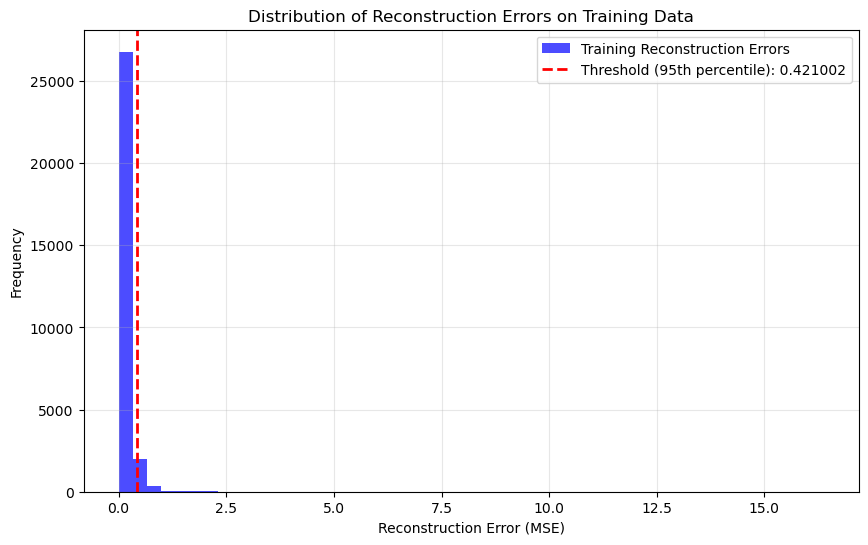

📊 Training error statistics:
   Mean: 0.150237
   Std:  0.228101
   Min:  0.006111
   Max:  16.370193


In [16]:
def calculate_reconstruction_errors(model, data_loader, device):
    """Calculate reconstruction errors for anomaly detection"""
    model.eval()
    all_errors = []
    all_data = []
    all_reconstructed = []
    
    with torch.no_grad():
        for batch_data, _ in data_loader:
            batch_data = batch_data.to(device)
            reconstructed = model(batch_data)
            
            # Calculate MSE for each sample
            errors = F.mse_loss(reconstructed, batch_data, reduction='none').mean(dim=1)
            
            all_errors.append(errors.cpu().numpy())
            all_data.append(batch_data.cpu().numpy())
            all_reconstructed.append(reconstructed.cpu().numpy())
    
    return (
        np.concatenate(all_errors),
        np.concatenate(all_data),
        np.concatenate(all_reconstructed)
    )

def detect_anomalies(model, data, threshold, device, batch_size=32):
    """Detect anomalies in new data"""
    # Create data loader
    data_loader = create_data_loader(data, batch_size=batch_size, shuffle=False)
    
    # Calculate reconstruction errors
    errors, original_data, reconstructed_data = calculate_reconstruction_errors(model, data_loader, device)
    
    # Detect anomalies
    is_anomaly = errors > threshold
    
    results = {
        'reconstruction_errors': errors,
        'is_anomaly': is_anomaly,
        'anomaly_scores': errors / threshold,  # Normalized scores
        'original_data': original_data,
        'reconstructed_data': reconstructed_data
    }
    
    return results

# Calculate threshold from training data
print("🔍 Calculating anomaly threshold from training data...")
train_errors, _, _ = calculate_reconstruction_errors(autoencoder, train_loader, device)
threshold = np.percentile(train_errors, 95)
print(f"Anomaly threshold (95th percentile): {threshold:.6f}")

# Log threshold to MLflow
with mlflow.start_run(run_id=run_id):
    mlflow.log_metric("anomaly_threshold_95pct", threshold)

# Visualize threshold distribution
plt.figure(figsize=(10, 6))
plt.hist(train_errors, bins=50, alpha=0.7, color='blue', label='Training Reconstruction Errors')
plt.axvline(threshold, color='red', linestyle='--', linewidth=2, label=f'Threshold (95th percentile): {threshold:.6f}')
plt.xlabel('Reconstruction Error (MSE)')
plt.ylabel('Frequency')
plt.title('Distribution of Reconstruction Errors on Training Data')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"📊 Training error statistics:")
print(f"   Mean: {np.mean(train_errors):.6f}")
print(f"   Std:  {np.std(train_errors):.6f}")
print(f"   Min:  {np.min(train_errors):.6f}")
print(f"   Max:  {np.max(train_errors):.6f}")

🧪 Testing anomaly detection on validation data...

🔍 Validation Set Anomaly Detection Results:
🚨 Anomalies detected: 376 / 7310
📈 Anomaly rate: 5.1%
📊 Average reconstruction error: 0.148946
📊 Max reconstruction error: 6.986085

🎯 Testing on known anomalies (customers who subscribed)...

🔍 Known Anomalies Detection Results:
🚨 Detected as anomalies: 1654 / 4640
📈 Detection rate: 35.6%
📊 Average reconstruction error: 0.423041


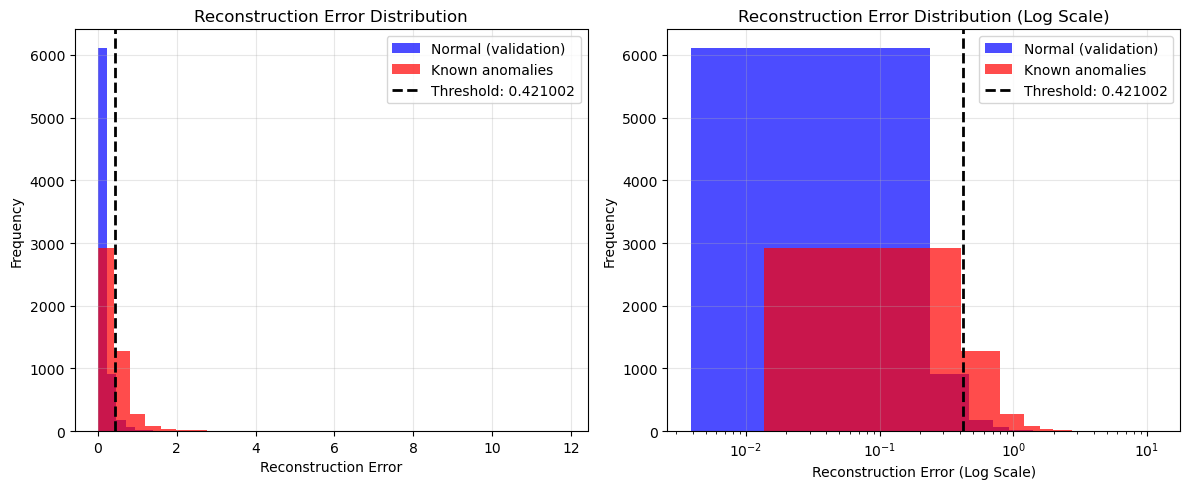

2025/08/06 06:21:58 WARNING mlflow.utils.requirements_utils: Found triton version (3.2.0+git576374f8) contains a local version label (+git576374f8). MLflow logged a pip requirement for this package as 'triton==3.2.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/08/06 06:21:58 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'banking-autoencoder-anomaly-detection' already exists. Creating a new version of this model...
2025/08/06 06:21:59 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: banking-autoencoder-anomaly-detection, version 3


🏃 View run pytorch_autoencoder_banking at: https://us-west-2.experiments.sagemaker.aws/#/experiments/1/runs/71decaee0c4a43b2a78a0d86251a8712
🧪 View experiment at: https://us-west-2.experiments.sagemaker.aws/#/experiments/1

💾 Model saved to: pytorch_autoencoder_model.pth
📝 Model logged to MLflow

🎯 PYTORCH AUTOENCODER ANOMALY DETECTION MODEL READY!
✅ Key advantages over TensorFlow version:
   🚀 Better SageMaker GPU compatibility
   🔧 No libdevice.10.bc errors
   💪 Robust CPU/GPU fallback
   📊 Optimized for banking anomaly detection

📋 Next steps:
1. 📦 Move to SageMaker containers (02-sagemaker-containers.ipynb)
2. 🔧 Build ML pipeline (03-sagemaker-pipeline.ipynb)
3. 🚀 Set up streaming inference via SQS
4. 📊 Add monitoring (06-monitoring.ipynb)


Created version '3' of model 'banking-autoencoder-anomaly-detection'.


In [17]:
# Test anomaly detection on validation data
print("🧪 Testing anomaly detection on validation data...")
val_results = detect_anomalies(autoencoder, X_val, threshold, device)

print(f"\n🔍 Validation Set Anomaly Detection Results:")
print(f"🚨 Anomalies detected: {np.sum(val_results['is_anomaly'])} / {len(X_val)}")
print(f"📈 Anomaly rate: {100 * np.mean(val_results['is_anomaly']):.1f}%")
print(f"📊 Average reconstruction error: {np.mean(val_results['reconstruction_errors']):.6f}")
print(f"📊 Max reconstruction error: {np.max(val_results['reconstruction_errors']):.6f}")

# Test on known anomalies if available
if X_anomaly_validation is not None:
    print("\n🎯 Testing on known anomalies (customers who subscribed)...")
    anomaly_results = detect_anomalies(autoencoder, X_anomaly_validation, threshold, device)
    
    print(f"\n🔍 Known Anomalies Detection Results:")
    print(f"🚨 Detected as anomalies: {np.sum(anomaly_results['is_anomaly'])} / {len(X_anomaly_validation)}")
    print(f"📈 Detection rate: {100 * np.mean(anomaly_results['is_anomaly']):.1f}%")
    print(f"📊 Average reconstruction error: {np.mean(anomaly_results['reconstruction_errors']):.6f}")
    
    # Compare error distributions
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.hist(val_results['reconstruction_errors'], bins=30, alpha=0.7, color='blue', label='Normal (validation)')
    plt.hist(anomaly_results['reconstruction_errors'], bins=30, alpha=0.7, color='red', label='Known anomalies')
    plt.axvline(threshold, color='black', linestyle='--', linewidth=2, label=f'Threshold: {threshold:.6f}')
    plt.xlabel('Reconstruction Error')
    plt.ylabel('Frequency')
    plt.title('Reconstruction Error Distribution')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 2, 2)
    plt.hist(val_results['reconstruction_errors'], bins=30, alpha=0.7, color='blue', label='Normal (validation)')
    plt.hist(anomaly_results['reconstruction_errors'], bins=30, alpha=0.7, color='red', label='Known anomalies')
    plt.axvline(threshold, color='black', linestyle='--', linewidth=2, label=f'Threshold: {threshold:.6f}')
    plt.xlabel('Reconstruction Error (Log Scale)')
    plt.ylabel('Frequency')
    plt.title('Reconstruction Error Distribution (Log Scale)')
    plt.xscale('log')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Save model for SageMaker deployment
model_path = "pytorch_autoencoder_model.pth"
torch.save({
    'model_state_dict': autoencoder.state_dict(),
    'model_config': {
        'input_dim': input_dim,
        'encoding_dim': encoding_dim,
        'threshold': threshold
    },
    'scaler': scaler,
    'label_encoders': label_encoders,
    'feature_names': feature_names
}, model_path)

# Log model to MLflow
with mlflow.start_run(run_id=run_id):
    mlflow.pytorch.log_model(
        autoencoder, 
        "model",
        registered_model_name="banking-autoencoder-anomaly-detection"
    )
    mlflow.log_artifact(model_path)

print(f"\n💾 Model saved to: {model_path}")
print("📝 Model logged to MLflow")

print("\n" + "="*60)
print("🎯 PYTORCH AUTOENCODER ANOMALY DETECTION MODEL READY!")
print("="*60)
print("✅ Key advantages over TensorFlow version:")
print("   🚀 Better SageMaker GPU compatibility")
print("   🔧 No libdevice.10.bc errors")
print("   💪 Robust CPU/GPU fallback")
print("   📊 Optimized for banking anomaly detection")
print("\n📋 Next steps:")
print("1. 📦 Move to SageMaker containers (02-sagemaker-containers.ipynb)")
print("2. 🔧 Build ML pipeline (03-sagemaker-pipeline.ipynb)")
print("3. 🚀 Set up streaming inference via SQS")
print("4. 📊 Add monitoring (06-monitoring.ipynb)")
print("="*60)